In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from sklearn.model_selection import train_test_split
# ========================================================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Data
from tqdm import tqdm
from glob import glob
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visulization
import matplotlib.pyplot as plt

# Model Layers
from keras.models import Model
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, ReLU
from keras.models import Sequential

# Backbone
from tensorflow.keras.applications import ResNet50

# Model Architecture Visualization
from tensorflow.keras.utils import plot_model

# Optimizer
from tensorflow.keras.optimizers import Adam

# Callbacks
from keras.callbacks import ModelCheckpoint, Callback
import cv2
# =====================================================



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [ ]:
def load_image(path: str, size: tuple = (256, 256), mask: bool = False):
    image = load_img(path)
    image = img_to_array(image)
    image = cv2.resize(image, size)
    # Move scaling after resizing
    image = tf.cast(image, tf.float32) / 255.0
    if mask:
        image = image[:, :, :1]
    return image

In [ ]:
def load_data(root_path:str):
    image_paths = sorted(glob(os.path.join(root_path, "Image/*.jpg")))
    mask_paths = [path.replace("Image", "Mask").replace("jpg", "png") for path in image_paths]

    images = np.empty(shape=(len(image_paths), 256, 256, 3), dtype=np.float32)
    masks = np.empty(shape=(len(image_paths), 256, 256, 1), dtype=np.float32)

    for i, (img_path, mask_path) in enumerate(tqdm(zip(image_paths, mask_paths), desc="Loading")):
        images[i] = load_image(img_path, mask=False)
        masks[i] = load_image(mask_path, mask=True)

    return images, masks


In [ ]:
def rotate_image(image, angle, target_size=(256, 256)):
    is_tensor = tf.is_tensor(image)
    if is_tensor:
        image = image.numpy()

    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, matrix, (w, h))

    rotated_image = center_crop_or_pad(rotated_image, target_size)
    if is_tensor:
        rotated_image = tf.convert_to_tensor(rotated_image)

    return rotated_image

In [ ]:
def center_crop_or_pad(image, target_size):
    h, w = image.shape[:2]
    th, tw = target_size

    x1 = max(0, (w - tw) // 2)
    y1 = max(0, (h - th) // 2)
    x2 = min(w, x1 + tw)
    y2 = min(h, y1 + th)
    image = image[y1:y2, x1:x2]

    if image.shape[:2] != target_size:
        pad_top = max(0, (th - h) // 2)
        pad_bottom = max(0, th - h - pad_top)
        pad_left = max(0, (tw - w) // 2)
        pad_right = max(0, tw - w - pad_left)
        padding = [(pad_top, pad_bottom), (pad_left, pad_right)]
        if image.ndim == 3:
            padding.append((0, 0))
        image = np.pad(image, padding, mode='constant')

    return image

In [ ]:
# def load_and_augment_data(root_path:str, rotation_angles=(45, 90, 135, 180, 225, 270, 315, 360)):
#     image_paths = sorted(glob(os.path.join(root_path, "Image/*.jpg")))
#     mask_paths = [path.replace("Image", "Mask").replace("jpg", "png") for path in image_paths]

#     images = []
#     masks = []

#     for i, (img_path, mask_path) in enumerate(tqdm(zip(image_paths, mask_paths), desc="Loading & Augmenting")):
#         original_image = load_image(img_path, mask=False)
#         original_mask = load_image(mask_path, mask=True)


#         for angle in rotation_angles:
#             rotated_image = rotate_image(original_image, angle)
#             rotated_mask = rotate_image(original_mask, angle)
#             images.append(rotated_image)
#             masks.append(rotated_mask)

#     all_images = np.array(images)
#     all_masks = np.array(masks)
#     return all_images, all_masks

# def load_and_augment_data(root_path: str, rotation_angles=(45, 90, 135, 180, 225, 270, 315, 360)):
#     image_paths = sorted(glob(os.path.join(root_path, "Image/*.jpg")))
#     mask_paths = [path.replace("Image", "Mask").replace("jpg", "png") for path in image_paths]

#     original_images = np.array([load_image(path, mask=False) for path in image_paths])
#     original_masks = np.array([load_image(path, mask=True) for path in mask_paths])

#     train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     original_images, original_masks, test_size=0.2, shuffle=False)
#     val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, shuffle=False )

#     train_masks = np.squeeze(train_masks, axis=3)
#     val_masks = np.squeeze(val_masks, axis=3)
#     test_masks = np.squeeze(test_masks, axis=3)
#     augmented_images = []
#     augmented_masks = []
#     for img, msk in zip(train_images, train_masks):
#         for angle in rotation_angles:
#             rotated_image = rotate_image(img, angle)
#             rotated_mask = rotate_image(msk, angle)
#             augmented_images.append(rotated_image)
#             augmented_masks.append(rotated_mask)

#     train_images = np.concatenate([train_images, np.array(augmented_images)], axis=0)
#     train_masks = np.concatenate([train_masks, np.array(augmented_masks)], axis=0)

#     return train_images,val_images, test_images, train_masks,val_masks, test_masks

def load_and_augment_data(root_path: str, rotation_angles=(45, 90, 135, 180, 225, 270, 315, 360)):
    image_paths = sorted(glob(os.path.join(root_path, "Image/*.jpg")))
    mask_paths = [path.replace("Image", "Mask").replace("jpg", "png") for path in image_paths]

    original_images = np.array([load_image(path, mask=False) for path in image_paths])
    original_masks = np.array([load_image(path, mask=True) for path in mask_paths])

    train_images, val_test_images, train_masks, val_test_masks = train_test_split(
        original_images, original_masks, test_size=0.2, shuffle=False)
    val_images, test_images, val_masks, test_masks = train_test_split(
        val_test_images, val_test_masks, test_size=0.5, shuffle=False)

    augmented_images = []
    augmented_masks = []
    for img, msk in zip(train_images, train_masks):
        for angle in rotation_angles:
            rotated_image = rotate_image(img, angle)
            rotated_mask = rotate_image(msk, angle)
            augmented_images.append(rotated_image)
            augmented_masks.append(rotated_mask)

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Ensure all arrays have the same number of dimensions
    if augmented_masks.ndim == 3:
        augmented_masks = np.expand_dims(augmented_masks, axis=-1)
    if train_masks.ndim == 3:
        train_masks = np.expand_dims(train_masks, axis=-1)
    if val_masks.ndim == 3:
        val_masks = np.expand_dims(val_masks, axis=-1)
    if test_masks.ndim == 3:
        test_masks = np.expand_dims(test_masks, axis=-1)

    train_images = np.concatenate([train_images, augmented_images], axis=0)
    train_masks = np.concatenate([train_masks, augmented_masks], axis=0)

    return train_images, val_images, test_images, train_masks, val_masks, test_masks

In [ ]:
train_images, val_images,test_images, train_masks, val_masks , test_masks= load_and_augment_data("/content/drive/MyDrive/flood")

In [ ]:
def show_images(images, masks, n_images, SIZE=(15,8)) -> None:
    for i in range(n_images):
        plt.figure(figsize=SIZE)
        id = np.random.randint(len(images))
        plt.subplot(1, 3, 1)
        plt.imshow(images[id])
        plt.title("Image")
        plt.axis('off')

        # Plot the Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[id], cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        # Plot the Overlapping Mask
        plt.subplot(1, 3, 3)
        plt.imshow(images[id], cmap='gray')
        plt.imshow(masks[id], cmap='gray', alpha=0.5)
        plt.title("Overlapping Mask")
        plt.axis('off')

        # Shwo a Single Frame : This is done to speed up plotting for large number images
        plt.tight_layout()
        plt.show()

In [ ]:
show_images(train_images, train_masks, n_images=10)

In [ ]:
image_size = (256, 256, 3)
def unet(sz=image_size):
    x = Input(sz)
    inputs = x

    #downsampling
    f = 8 #number of filters
    layers = []
    for i in range(6):
        x = Conv2D(f, 3, activation='relu',padding='same')(x)
        x = Conv2D(f, 3, activation='relu',padding='same')(x)
        layers.append(x)
        x = MaxPooling2D()(x)
        f = f*2
    ff2 = 64

    #bottleneck
    j = len(layers)-1
    x = Conv2D(f, 3, activation='relu',padding='same')(x)
    x = Conv2D(f, 3, activation='relu',padding='same')(x)
    x = Conv2DTranspose(ff2, 2, strides=(2,2),padding='same')(x)
    x = Concatenate(axis=3)([x,layers[j]])
    j = j-1

    #upsampling
    for i in range(5):
        ff2 = ff2//2
        f = f//2
        x = Conv2D(f, 3, activation='relu',padding='same')(x)
        x = Conv2D(f, 3, activation='relu',padding='same')(x)
        x = Conv2DTranspose(ff2, 2, strides=(2,2),padding='same')(x)
        x = Concatenate(axis=3)([x,layers[j]])
        j = j-1
    #classification
    x = Conv2D(f, 3, activation='relu',padding='same')(x)
    x = Conv2D(f, 3, activation='relu',padding='same')(x)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(x)
    model = Model(inputs=[inputs], outputs = [outputs])

    return model

In [ ]:
model = unet()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 8)    │            224 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 8)    │            584 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 8)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 16)   │          1,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 16)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 32)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 64)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 8, 8, 128)      │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_4[0][0]  │
├──────────────────────

 Total params: 6,667,639 (25.44 MB)

 Trainable params: 6,667,639 (25.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

In [ ]:
# def IoU(y_true, y_pred, smooth=1):
#   # Convert masks to binary format before calculations
#   y_true = tf.cast(y_true > 0.5, tf.float32)
#   y_pred = tf.cast(y_pred > 0.5, tf.float32)

#   intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
#   sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2])
#   jac = (intersection + smooth) / (sum_ - intersection + smooth)
#   return K.mean(jac)
def IoU(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2]) # Use tf.reduce_sum
    sum_ = tf.reduce_sum(tf.abs(y_true) + tf.abs(y_pred), axis=[1,2]) # Use tf.reduce_sum
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
def precision(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def precision(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * ((p * r) / (p + r + K.epsilon()))
    return f1

In [ ]:
# def dice_coef(y_true, y_pred):
#     smooth = 1.
#     y_true = tf.cast(y_true > 0.5, tf.float32)  # Convert to binary
#     y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert to binary
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)  # Convert to binary
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert to binary
    y_true_f = tf.keras.backend.flatten(y_true) # Use tf.keras.backend.flatten
    y_pred_f = tf.keras.backend.flatten(y_pred) # Use tf.keras.backend.flatten
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)
    dice = (2. * intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
    return dice


In [ ]:
# def recall(y_true, y_pred):
#     y_true = tf.cast(y_true > 0.5, tf.float32)
#     y_pred = tf.cast(y_pred > 0.5, tf.float32)

#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall
def recall(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1))) # Use tf functions
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1))) # Use tf functions
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon()) # Keep using tf.keras.backend for epsilon
    return recall

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=[
        "accuracy",
        IoU,
        dice_coef,
        precision,
        recall,
        f1_score
    ]
)

In [ ]:
loss_values = []
accuracy_values = []
iou_values = []
dice_values = []
precision_values = []
recall_values = []
f1_values = []
jaccard_values = []
# =================================


In [ ]:
callbacks = [
    ModelCheckpoint("01ResNetDeepLabV3+.keras", save_best_only=True),
]

In [ ]:
history =  model.fit(
    train_images, train_masks,
    validation_data=(test_images, test_masks),
    epochs=50,
    callbacks=callbacks,
    batch_size=10,
)

Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 60s 163ms/step - accuracy: 0.7161 - dice_coef: 0.5505 - f1_score: 0.5505 - io_u: 0.4133 - loss: 0.5370 - precision: 0.7070 - recall: 0.5415 - val_accuracy: 0.8597 - val_dice_coef: 0.8248 - val_f1_score: 0.8248 - val_io_u: 0.6727 - val_loss: 0.3174 - val_precision: 0.8731 - val_recall: 0.7829
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.7977 - dice_coef: 0.7588 - f1_score: 0.7588 - io_u: 0.6017 - loss: 0.4065 - precision: 0.7858 - recall: 0.7471 - val_accuracy: 0.8659 - val_dice_coef: 0.8451 - val_f1_score: 0.8451 - val_io_u: 0.7077 - val_loss: 0.2975 - val_precision: 0.8288 - val_recall: 0.8637
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.8176 - dice_coef: 0.7782 - f1_score: 0.7782 - io_u: 0.6227 - loss: 0.3687 - precision: 0.8144 - recall: 0.7571 - val_accuracy: 0.8820 - val_dice_coef: 0.8472 - val_f1_score: 0.8472 - val_io_u: 0.7179 - val_loss: 0.2740 - val_precision: 0.9040 - val_recall: 0.7974
Epo

In [ ]:
model.save('/content/drive/MyDrive/archive/final_Unet_model_50epocs.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


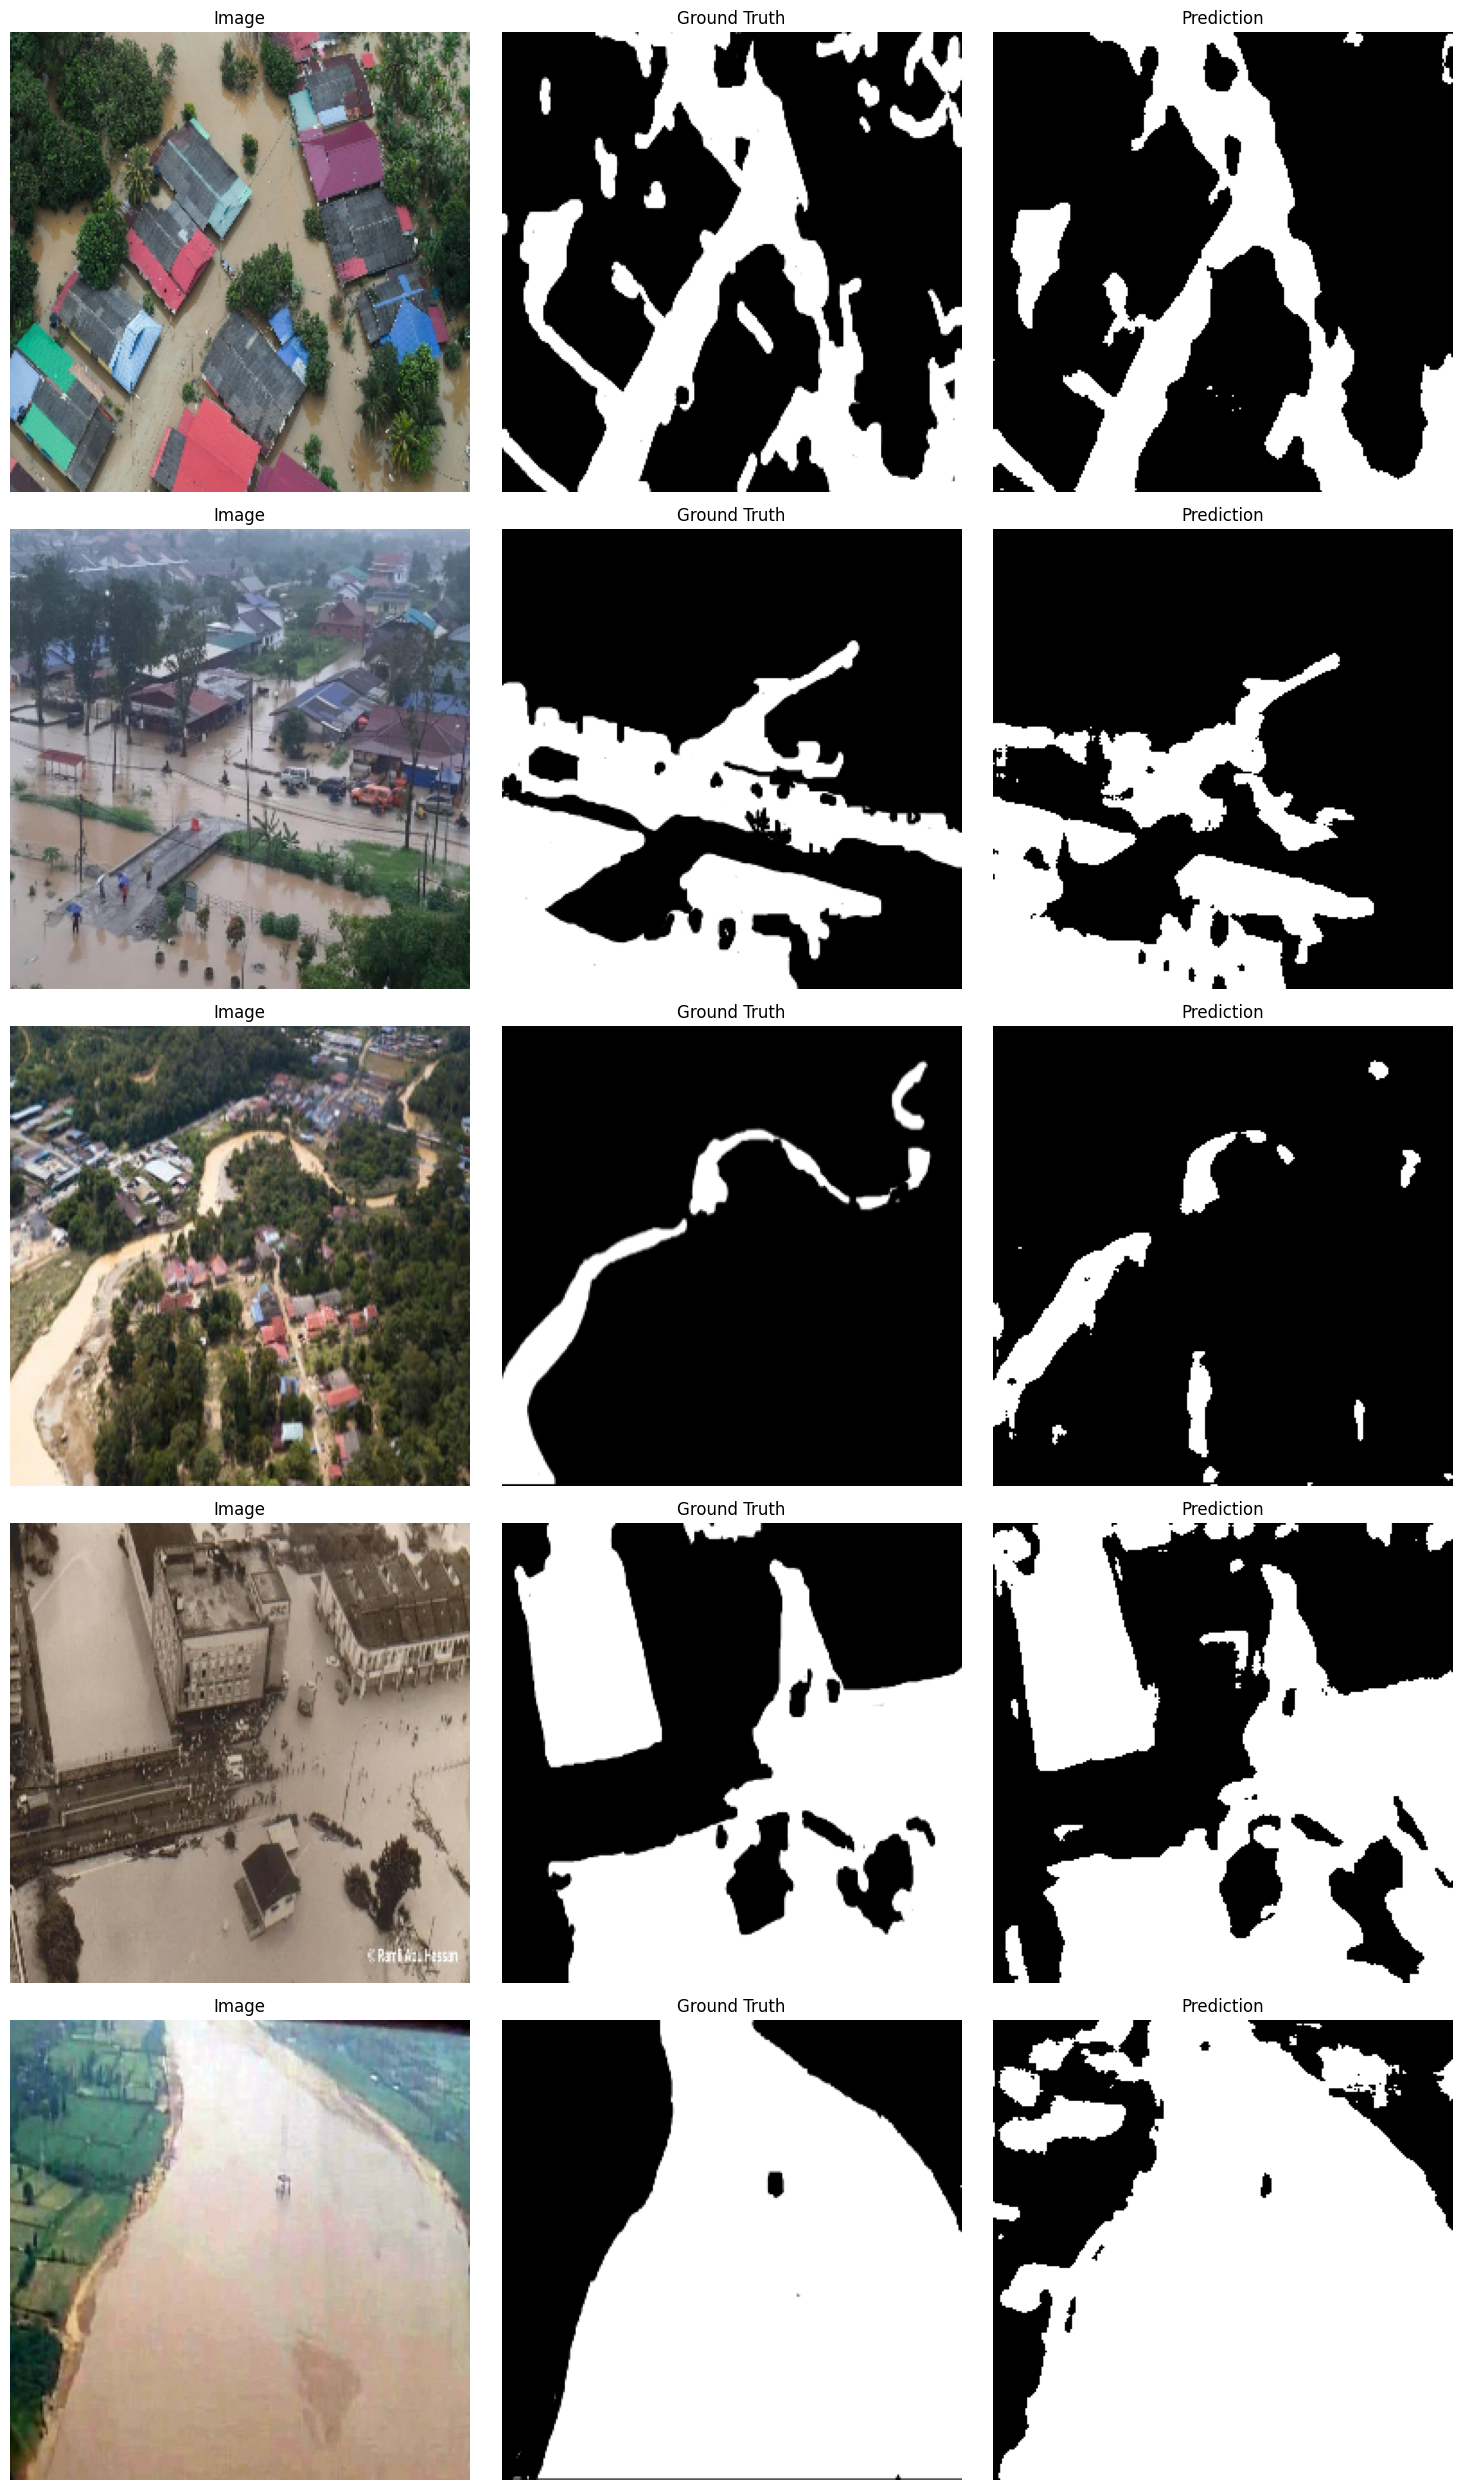

In [ ]:
def display_samples(images, masks, preds, num_samples=5):
    fig, axes = plt.subplots(nrows=num_samples, ncols=3, figsize=(15, num_samples * 5))  # Adjusted figsize

    for i in range(num_samples):
        # Original Image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        # Ground Truth Mask
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Prediction (Without Overlay)
        axes[i, 2].imshow(preds[i], cmap='gray')  # Show prediction in grayscale
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


test_samples = test_images[:10]
ground_truth_masks = test_masks[:10]
predictions =model.predict(test_samples)

predictions = np.squeeze(predictions, axis=3)
predictions = (predictions > 0.5).astype(np.uint8)
display_samples(test_samples, ground_truth_masks, predictions)

In [ ]:
loss_values = history.history['loss']
val_loss = history.history['val_loss']
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']
iou_values = history.history['io_u']
dice_values = history.history['dice_coef']
precision_values = history.history['precision']
recall_values = history.history['recall']
f1_values = history.history['f1_score']
val_loss = history.history['val_loss']
val_accuracy_values = history.history['val_accuracy']
val_iou = history.history['val_io_u']

In [ ]:
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, loss_values, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy_values, 'g', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 8))

axs[0, 0].plot(epochs, accuracy_values, 'g', label='Training Accuracy')
axs[0, 0].set_title('Training Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

axs[0, 1].plot(epochs, loss_values, 'r', label='Training Loss')
axs[0, 1].set_title('Training Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

axs[0, 2].plot(epochs, val_loss, 'b', label='Validation Loss')
axs[0, 2].set_title('Validation Loss')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].legend()

axs[1, 0].plot(epochs, val_accuracy_values, 'k', label='Validation Accuracy')
axs[1, 0].set_title('Validation Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

axs[1, 1].plot(epochs, iou_values, 'y', label='IoU')
axs[1, 1].set_title('IoU')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Metric Value')
axs[1, 1].legend()

axs[1, 2].plot(epochs, dice_values, 'c', label='Dice Coefficient')
axs[1, 2].set_title('Dice Coefficient')
axs[1, 2].set_xlabel('Epochs')
axs[1, 2].set_ylabel('Metric Value')
axs[1, 2].legend()

axs[2, 0].plot(epochs, precision_values, 'm', label='Precision')
axs[2, 0].set_title('Precision')
axs[2, 0].set_xlabel('Epochs')
axs[2, 0].set_ylabel('Metric Value')
axs[2, 0].legend()

axs[2, 1].plot(epochs, recall_values, 'b', label='Recall')
axs[2, 1].set_title('Recall')
axs[2, 1].set_xlabel('Epochs')
axs[2, 1].set_ylabel('Metric Value')
axs[2, 1].legend()

axs[2, 2].plot(epochs, f1_values, 'k', label='F1 Score')
axs[2, 2].set_title('F1 Score')
axs[2, 2].set_xlabel('Epochs')
axs[2, 2].set_ylabel('Metric Value')
axs[2, 2].legend()

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [ ]:
print("Training Loss:",loss_values)

In [ ]:
print("Validation Loss:",val_loss)

In [ ]:
print("Training Accuracy:",accuracy_values)

In [ ]:
print("Valdiation Accuracy:",val_accuracy_values)
print("IOU:",iou_values)
print("Dice Cofficiexnt:",dice_values)
print("Precision:",precision_values)
print("Recall:", recall_values)
print("F1 score:",f1_values)
print("Val Loss", val_loss)
print("Val Accuracy", val_accuracy_values)
print("Val IOU", val_iou)

Valdiation Accuracy: [0.859740674495697, 0.865871012210846, 0.8819853663444519, 0.8735372424125671, 0.8857437372207642, 0.8712636828422546, 0.8827467560768127, 0.892546534538269, 0.8940329551696777, 0.8949947953224182, 0.9026694297790527, 0.9072044491767883, 0.8901214599609375, 0.9020001888275146, 0.908507227897644, 0.906829297542572, 0.905971109867096, 0.9087619185447693, 0.9099368453025818, 0.8998144865036011, 0.8928869962692261, 0.9084909558296204, 0.9121635556221008, 0.9061163663864136, 0.9111054539680481, 0.9092128276824951, 0.9112001657485962, 0.9005516171455383, 0.9155762791633606, 0.9160966277122498, 0.916350245475769, 0.9173636436462402, 0.9154610633850098, 0.9164628386497498, 0.9181624054908752, 0.9198676943778992, 0.9172778725624084, 0.9156357049942017, 0.9167227745056152, 0.9102409482002258, 0.9124076962471008, 0.9220696687698364, 0.9156635999679565, 0.916138231754303, 0.9186343550682068, 0.9192178845405579, 0.9171631932258606, 0.9068877100944519, 0.9195414781570435, 0.9156